In [29]:
from qutip import *
import numpy as np
import sympy as sp
from qiskit import QuantumCircuit

rho_0 = Qobj([[1,0],[0,0]])
rho_1 = Qobj([[0,0],[0,1]])

I =  qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

c = 1/np.sqrt(1)

r = c*np.array([0.5,0,0])       #[rx,ry,rz]

rho_a = 1/2*(I+r[0]*X + r[1]*Y + r[2]*Z)
# rho_a = Qobj([[0,0],[0,1]])

rho = tensor(rho_a,rho_0,rho_0)
rho_a


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [30]:
def some(n=3, name='xh'):
    qc = QuantumCircuit(n, name=name)
    qc.x(0)
    qc.x(0)
    return qc

U_gate = some().to_gate()
U_gate.label = "Error"


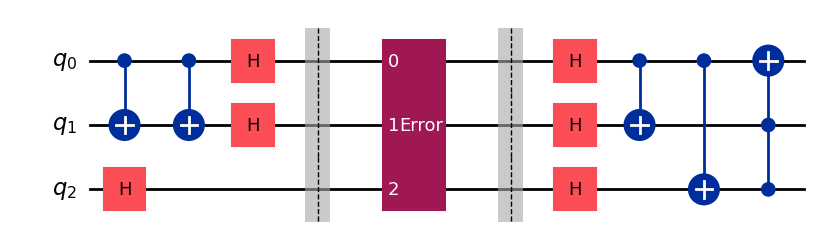

In [31]:
qc = QuantumCircuit(3)

qc.cx(0,1)
qc.cx(0,1)

qc.h([0,1,2])
qc.barrier()
qc.append(U_gate,[0,1,2])
qc.barrier()

qc.h([0,1,2])
qc.cx(0,1)
qc.cx(0,2)
qc.ccx(1,2,0)

qc.draw('mpl')

Assuming perfect error correction


In [3]:
p = 0.5
K_0 = np.sqrt(p)*tensor(X,X,X)
K_1 = np.sqrt(1-p)*tensor(I,I,I)


In [4]:

U_1 = tensor(rho_0,I,I) + tensor(rho_1,X,I)
U_2 = tensor(rho_0,I,I) + tensor(rho_1,I,X)
U_4 = U_1
U_5 = U_2
U_6 = tensor(I,rho_0,rho_0) + tensor(I,rho_0,rho_1) + tensor(I,rho_1,rho_0) + tensor(X,rho_1,rho_1)

In [5]:
Ua = U_6@U_5@U_4@K_0@U_2@U_1
Ub = U_6@U_5@U_4@K_1@U_2@U_1



In [6]:
final = Ub@rho@Ub.trans() + Ua@rho@Ua.trans()
final
# d

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5  0.   0.   0.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.   0.5  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]

In [7]:
reduced_rho = final.ptrace(0)
reduced_rho

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [8]:
rho_a

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.5  0.25]
 [0.25 0.5 ]]

In [9]:
fidelity(rho_a,reduced_rho)

0.9999999999999998

In [20]:
def bitflip(x,y,z,p):

    rho_0 = Qobj([[1,0],[0,0]])
    rho_1 = Qobj([[0,0],[0,1]])

    I =  qeye(2)
    X = sigmax()
    Y = sigmay()
    Z = sigmaz()

    rho_initial = 1/2*(I+x*X + y*Y + z*Z)
    # rho_a = Qobj([[0,0],[0,1]])

    rho = tensor(rho_initial,rho_0,rho_0)

    #Defining the Kraus operators corresponding to the error
    K_0 = np.sqrt(p)*tensor(X,X,X)
    K_1 = np.sqrt(1-p)*tensor(I,I,I)

    #defining the gates corresponding to the bit flip circuit
    U_1 = tensor(rho_0,I,I) + tensor(rho_1,X,I)
    U_2 = tensor(rho_0,I,I) + tensor(rho_1,I,X)
    U_4 = U_1
    U_5 = U_2
    U_6 = tensor(I,rho_0,rho_0) + tensor(I,rho_0,rho_1) + tensor(I,rho_1,rho_0) + tensor(X,rho_1,rho_1)

    Ua = U_6@U_5@U_4@K_0@U_2@U_1
    Ub = U_6@U_5@U_4@K_1@U_2@U_1

    final = Ub@rho@Ub.trans() + Ua@rho@Ua.trans()
    reduced_rho = final.ptrace(0)

    ans = fidelity(rho_initial,reduced_rho)
    return  ans

In [21]:
ans = bitflip(0.5,0,0.5,0.7)
ans

0.9342961961794154

In [22]:
def generate_fidelity_data(bitflip, step):
    # Initialize an empty list to store the results
    fidelity_data = []

    # Iterate over values of x, y, z
    for x in np.arange(-1, 1 + step, step):
        
        for y in np.arange(-1, 1 + step, step):

            for z in np.arange(-1, 1 + step, step):
                if x**2 + y**2 + z**2 <= 1:
                    
                    for p in np.arange(0, 1 + step, step):
                        fidelity = bitflip(x, y, z, p)
                        fidelity_data.append((x, y, z, p, fidelity))
    
    return fidelity_data

In [23]:
fidelity_results = generate_fidelity_data(bitflip, 0.1)
# print(np.size(fidelity_results))

In [25]:
print(np.shape(fidelity_results))

(45793, 5)


In [26]:
fidelity_data = np.array(fidelity_results)

# Extract the p values and fidelity values
p_values = fidelity_data[:, 3]
fidelity_values = fidelity_data[:, 4]

# Get the unique p values
unique_p_values = np.unique(p_values)


In [27]:
average_fidelity_by_p = {p: np.mean(fidelity_values[p_values == p]) for p in unique_p_values}

# Print the average fidelity for each distinct value of p
for p, avg_fidelity in average_fidelity_by_p.items():
    print(f"Average Fidelity for p={np.round(p,2)}: {np.round(avg_fidelity,3)}")

Average Fidelity for p=0.0: 1.0
Average Fidelity for p=0.1: 0.994
Average Fidelity for p=0.2: 0.983
Average Fidelity for p=0.3: 0.968
Average Fidelity for p=0.4: 0.95
Average Fidelity for p=0.5: 0.93
Average Fidelity for p=0.6: 0.906
Average Fidelity for p=0.7: 0.878
Average Fidelity for p=0.8: 0.845
Average Fidelity for p=0.9: 0.805
Average Fidelity for p=1.0: 0.752


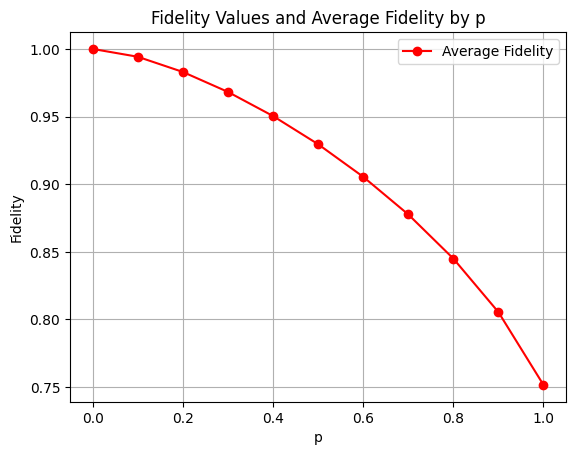

In [28]:
import matplotlib.pyplot as plt

# plt.scatter(p_values, fidelity_values, label='Fidelity Values', alpha=0.6)

# Plot the average fidelity for each p value
avg_p = np.array(list(average_fidelity_by_p.keys()))
avg_fidelity = np.array(list(average_fidelity_by_p.values()))
plt.plot(avg_p, avg_fidelity, color='red', label='Average Fidelity', marker='o')

# Add labels and title
plt.xlabel('p')
plt.ylabel('Fidelity')
plt.title('Fidelity Values and Average Fidelity by p')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()